In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools
import os

from ResNet import ResNet

In [2]:
IMAGE_SIZE = [100, 100]

In [3]:
train_path = 'large_files/fruits-360-original-size/fruits-360-original-size/Training'
valid_path = 'large_files/fruits-360-original-size/fruits-360-original-size/Validation'

In [4]:
image_files = []
for category in os.listdir(train_path):
    category_path = os.path.join(train_path, category)
    if os.path.isdir(category_path):
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpg'):
                image_files.append(os.path.join(category_path, file_name))

In [5]:
valid_image_files = []
for category in os.listdir(valid_path):
    category_path = os.path.join(valid_path, category)
    if os.path.isdir(category_path):
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpg'):
                valid_image_files.append(os.path.join(category_path, file_name))

In [6]:
folders = glob(train_path + '/*')

In [7]:
resnet = ResNet(num_classes=len(folders))

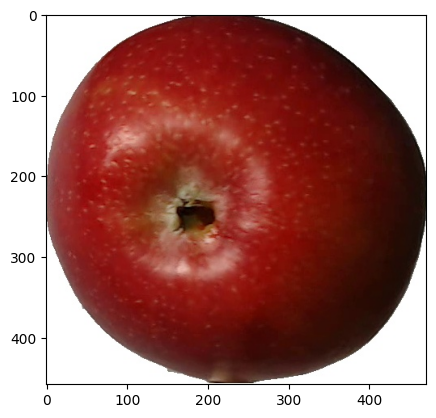

In [8]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [9]:
def preprocess_input(x):
    x = x / 255.
    x = x - 0.5
    x = x * 2.
    return x

In [10]:
batch_size = 32

gen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

gen_valid = ImageDataGenerator()

train_generator = gen_train.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
)

valid_generator = gen_valid.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


In [11]:
valid_generator.n

3114

In [12]:
history = {'train_loss': [], 'train_accuracy': [], 'valid_loss': [], 'valid_accuracy': []}

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = Adam(learning_rate=0.001)

train_loss_metric = tf.metrics.Mean()
train_accuracy_metric = tf.metrics.CategoricalAccuracy()
valid_loss_metric = tf.metrics.Mean()
valid_accuracy_metric = tf.metrics.CategoricalAccuracy()

epochs = 15
i = 0
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')

    for step in range(steps_per_epoch):
        x_batch, y_batch = next(train_generator)

        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = resnet(x_batch)
            loss_value = loss(y_batch, y_pred)

        # Backpropagation
        grads = tape.gradient(loss_value, resnet.trainable_weights)
        optimizer.apply_gradients(zip(grads, resnet.trainable_weights))

        # Update metrics
        train_loss_metric.update_state(loss_value)
        train_accuracy_metric.update_state(y_batch, y_pred)

        # Print status every 10 batches
        if i % 10 == 0:
            print(f'Step {i}: loss = {loss_value.numpy()}, accuracy = {train_accuracy_metric.result().numpy()}')
        i += 1

    for step in range(validation_steps):
        x_batch, y_batch = next(valid_generator)
        y_pred = resnet(x_batch)
        loss_value = loss(y_batch, y_pred)

        valid_loss_metric.update_state(loss_value)
        valid_accuracy_metric.update_state(y_batch, y_pred)

    valid_generator.reset()

    history['train_loss'].append(train_loss_metric.result().numpy())
    history['train_accuracy'].append(train_accuracy_metric.result().numpy())
    history['valid_loss'].append(valid_loss_metric.result().numpy())
    history['valid_accuracy'].append(valid_accuracy_metric.result().numpy())

    print(f"Train loss: {train_loss_metric.result().numpy()}, Train accuracy: {train_accuracy_metric.result().numpy()}")
    print(f"Valid loss: {valid_loss_metric.result().numpy()}, Valid accuracy: {valid_accuracy_metric.result().numpy()}")

    # reset the metrics for the next epoch
    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()
    valid_loss_metric.reset_states()
    valid_accuracy_metric.reset_states()

Epoch 1/15
Step 0: loss = 3.2014942169189453, accuracy = 0.0
Step 10: loss = 3.139504909515381, accuracy = 0.04261363670229912
Step 20: loss = 3.1715822219848633, accuracy = 0.061011902987957
Step 30: loss = 2.9035940170288086, accuracy = 0.06552419066429138
Step 40: loss = 2.925403356552124, accuracy = 0.07621951401233673
Step 50: loss = 2.711915969848633, accuracy = 0.0729166641831398
Step 60: loss = 2.7058191299438477, accuracy = 0.08760245889425278
Step 70: loss = 2.638031005859375, accuracy = 0.09991197288036346
Step 80: loss = 2.63259220123291, accuracy = 0.1041666641831398
Step 90: loss = 2.55191707611084, accuracy = 0.11778846383094788
Step 100: loss = 2.237502336502075, accuracy = 0.13180692493915558
Step 110: loss = 2.0039496421813965, accuracy = 0.1444256752729416
Step 120: loss = 2.0947444438934326, accuracy = 0.15418387949466705
Step 130: loss = 2.164811611175537, accuracy = 0.1619751900434494
Step 140: loss = 1.941387414932251, accuracy = 0.17641843855381012
Step 150: los

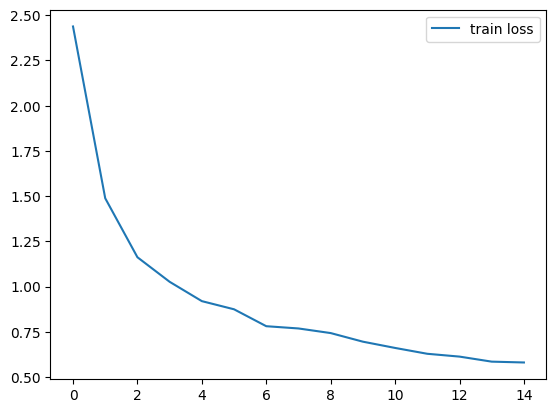

In [13]:
plt.plot(history['train_loss'], label='train loss')
plt.legend()

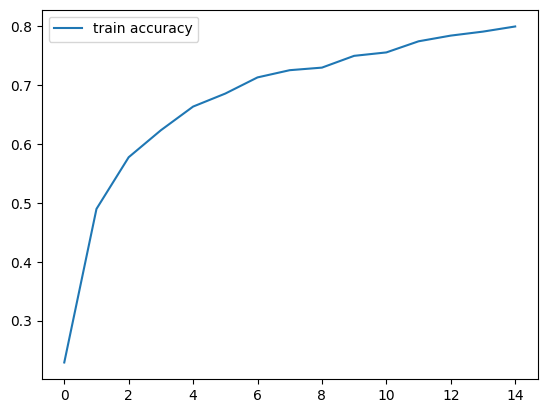

In [14]:
plt.plot(history['train_accuracy'], label='train accuracy')
plt.legend()